# Inverted Double Pendulum

In [3]:
#All of this code has been written from scratch as a personal project. I have used lecture notes and videos from 
#MIT's Underactuated Robotics course as a reference to write this code.
#Link to the course webpage: http://underactuated.csail.mit.edu/Spring2019/index.html

#The goal of this code is to implement the inverted pendulum for the double pendulum.
#This code will utilize the dynamics of the pendulum and invert the pendulum using
#a control law derived from a Lyapunov function, which changes the pendulum's energy to
#match the energy of the desired angles/angular velocities, and a control law derived from
#a LQR to balance the pendulum at the top.

#The pendulum system used is a simple double pendulum with no damping. The vertical axis going down from the origin
#represents theta=0 for both thetas (unlike the model shown in the course shown above) with counter-clockwise direction being positive.
#The double pendulum is an Acrobot, which means only the elbow joint is actuated.

import numpy as np
import matplotlib.pyplot as plt
import control
import matplotlib.animation as animation

In [835]:
#Create a class for the pendulum simulation
class SwingUpAndBalancePendulum():

    def __init__(self,control=True):
        self.PendulumParameters()      
        self.computeLQR()
        #Set control to True to see a controlled pendulum, set control to False to see an uncontrolled pendulum
        self.control=control
        
        
    #Initialize the parameters of the pendulum system
    def PendulumParameters(self,th_init=[0,0],om_init=[0,0]):        
        self.L=np.array([1,1],dtype='float')            #Initialize the link arm length
        self.m=np.array([1,1],dtype='float')            #Initialize mass at end of the link
        self.theta_init=np.array(th_init,dtype='float')   #Initialize the angle of the joint (in radians)
        self.omega_init=np.array(om_init,dtype='float')   #Initialize the angular velocity of the joint (in radians/sec)
        self.g=9.81                       #Initialize the acceleration due to gravity
        
        self.u_lim=20     #Define the constraint on the input (limit the magnitude of the input u)
        self.kp,self.kd=1.25,0.1     #Set the PD controller gains
        self.ke=0.8                  #Set the gain for the control law obtained through Lyapunov function
            #The gains shown above have been tuned as best as possible but these won't be able to accomplish 
            #the task within 20 secs of simulation time for some initial theta and omega
        
        #Define the desired energy state (the energy for the desired angle and angular velocity)
        self.th_des=np.array([np.pi,np.pi],dtype='float')    #The desired angle
        self.om_des=np.array([0,0],dtype='float')            #The desired angular velocity
        self.E_des=self.energy(self.th_des,self.om_des)    #The energy state based on desired angle and angular velocity
        
        self.dt=0.025    #Sampling time for simulation

    #Find the energy of the pendulum system
    def energy(self,theta,omega):
        #Find the kinetic energy of the system
        T=(1/2)*self.m[0]*self.L[0]**2*omega[0]**2+(1/2)*self.m[1]*(self.L[0]**2*omega[0]**2+
                    self.L[1]**2*omega[1]**2+2*self.L[0]*self.L[1]*omega[0]*omega[1]*np.cos(theta[0]-theta[1]))         
        #Find the potential energy of the system
        U=-(self.m[0]+self.m[1])*self.g*self.L[0]*np.cos(theta[0])-self.m[1]*self.g*self.L[1]*np.cos(theta[1])     
        E=T+U                      #Find the total energy of the system
        return E
    
    #Define the manipulator equation for the double pendulum,  M(q)*q''+C(q,q')*q'=torque_g+B*u, obtained from Lagrangian dynamics
    def eq_motion(self,theta,omega):
        a=(self.m[0]+self.m[1])*self.L[0]**2
        b=self.m[1]*self.L[1]**2
        c=self.m[1]*self.L[0]*self.L[1]*np.cos(theta[0]-theta[1])
        M=np.array([[a,c],
                    [c,b]],dtype='float')
        
        d=self.m[1]*self.L[0]*self.L[1]*np.sin(theta[0]-theta[1])
        C=np.array([[0, d*omega[1]],
                    [-d*omega[0], 0]],dtype='float')
        
        torque_g=-self.g*np.array([[(self.m[0]+self.m[1])*self.L[0]*np.sin(theta[0])],
                                    [self.m[1]*self.L[1]*np.sin(theta[1])]],dtype='float')

        B=np.array([[0],[1]])
        
        return M,C,torque_g,B
    
    #Set A and B as the matrices for the linearized pendulum system around the region of theta=np.pi and apply LQR
    #to obtain the gain constants to control the pendulum to stay up
    def computeLQR(self):
        M,C,t_g,B=self.eq_motion(self.th_des,self.om_des)
        dt_g=np.array([[(self.m[0]+self.m[1])*self.g*self.L[0],0],
                      [0,self.m[1]*self.g*self.L[1]]])
        
        A_part=np.dot(np.linalg.inv(M),dt_g)
        B_part=np.dot(np.linalg.inv(M),B)
        
        self.A=np.array([[0,0,1,0],
                         [0,0,0,1],
                         [A_part[0,0],A_part[0,1],0,0],
                         [A_part[1,0],A_part[1,1],0,0]])
        self.B=np.array([[0],
                         [0],
                         [B_part[0]],
                         [B_part[1]]])
        self.Q=np.diag((1,1,1,1))
        self.R=[0.004]
        self.k_LQR,self.S,e=control.lqr(self.A,self.B,self.Q,self.R)
    
    #Find the input value to drive the pendulum system
    def find_input(self,theta,omega):
        if self.control:
            #When thetas and omegas are close to 0 (i.e. initial thetas and omegas are all 0), set the input u to the input limit
            if theta[0]%(2*np.pi)<=0.25 and theta[1]%(2*np.pi)<=0.25 and abs(omega[0])<=0.25 and abs(omega[1])<=0.25:
                u=self.u_lim
            else:
                #Compute the error of the current states from the desired states
                xbar=np.array([(np.sign(theta[0])*(theta[0])%(2*np.pi)-self.th_des[0]),
                               (np.sign(theta[1])*(theta[1])%(2*np.pi)-self.th_des[1]),
                               (omega[0]-self.om_des[0]),
                               (omega[1]-self.om_des[1])])
                
                #If the cost is less than the specified value, compute input u using LQR
                if np.dot(np.transpose(xbar),np.dot(self.S,xbar))<11:
                    u=-np.transpose(np.dot(self.k_LQR,xbar))
                else:
                    #Calculate the difference between the current and desired energy
                    E_diff=self.energy(theta,omega)-self.E_des
                    
                    #Calculate the differnce between angle 1 and angle 2
                    th_diff=(theta[0])%(2*np.pi)-(theta[1])%(2*np.pi)
                    if abs(th_diff)>np.pi:
                        th_diff=th_diff-np.sign(th_diff)*2*np.pi
 
                    #Set the desired acceleration as a PD controller
                    th_acc_des=-self.kp*(th_diff)-self.kd*(omega[1]-self.om_des[1])
                    #Use partial feedback linearization (PFL) to calculate input u from desired acceleration
                    M,C,t_g,B=self.eq_motion(theta,omega)  
                    torque=t_g-np.dot(C,np.transpose(np.array([omega])))
                    v=(M[1,1]-M[1,0]/M[0,0]*M[0,1])*th_acc_des+M[1,0]/M[0,0]*(torque[0])-torque[1]
                    #Add the control law obtained from the Lyapunov function to the input computed from PFL
                    u=v-self.ke*(omega[1])*E_diff

            #If the magnitude of u is greater than the input limit, set u as the input limit
            if abs(u)>self.u_lim:
                u=np.sign(u)*self.u_lim
        else:
            u=0     #Set input as 0 when the system is not controlled
        return u

    #Find the accelerations using the manipulator equation 
    def find_ang_acc(self,M,C,torque_g,B,u,omega):
        Bu=np.array([[0],[u]])
        omega=np.array([omega])
        ang_acc=np.matmul(np.linalg.inv(M),(torque_g+Bu-np.matmul(C,np.transpose(omega))))
        ang_acc=np.array([ang_acc[0,0],ang_acc[1,0]])
        return ang_acc
    
    #The fourth order Runge-Kutta method is used to find the thetas and omegas of the next time step
    def RK4(self,theta,omega,u):
        d_theta1=self.dt*omega
        M1,C1,torque_g1,B1=self.eq_motion(theta,omega)
        d_omega1=self.dt*self.find_ang_acc(M1,C1,torque_g1,B1,u,omega)
        d_theta2=self.dt*(omega+d_omega1/2)
        M2,C2,torque_g2,B2=self.eq_motion(theta+d_theta1/2,omega+d_omega1/2)
        d_omega2=self.dt*self.find_ang_acc(M2,C2,torque_g2,B2,u,omega+d_omega1/2)
        d_theta3=self.dt*(omega+d_omega2/2)
        M3,C3,torque_g3,B3=self.eq_motion(theta+d_theta2/2,omega+d_omega2/2)
        d_omega3=self.dt*self.find_ang_acc(M3,C3,torque_g3,B3,u,omega+d_omega2/2)
        d_theta4=self.dt*(omega+d_omega3/2)
        M4,C4,torque_g4,B4=self.eq_motion(theta+d_theta3/2,omega+d_omega3/2)
        d_omega4=self.dt*self.find_ang_acc(M4,C4,torque_g4,B4,u,omega+d_omega3/2)
        
        d_theta=(d_theta1+2*(d_theta2+d_theta3)+d_theta4)/6
        d_omega=(d_omega1+2*(d_omega2+d_omega3)+d_omega4)/6

        theta_new=theta+d_theta
        omega_new=omega+d_omega
        
        return theta_new, omega_new

    #Simulate the pendulum system
    def simulate(self,n):
        theta_sim=np.zeros((n,2))    #Initialize an array for the angles
        omega_sim=np.zeros((n,2))    #Initialize an array for the angular velocities
        u_sim=np.zeros((n))        #Initialize an array for the control input
        E_sim=np.zeros((n))          #Initialize an array for the energy of the system
        
        theta_sim[0]=self.theta_init     #Set the initial theta to the array
        omega_sim[0]=self.omega_init     #Set the initial omega to the array
        E_sim[0]=self.energy(theta_sim[0],omega_sim[0])
        
        #Find the theta and omega of the next time step by computing the control input and using RK4
        for x in range(1,n):
            u_sim[x-1]=self.find_input(theta_sim[x-1],omega_sim[x-1])
            theta_next,omega_next=self.RK4(theta_sim[x-1],omega_sim[x-1],u_sim[x-1])
            E_sim[x]=self.energy(theta_next,omega_next)
            theta_sim[x]=theta_next
            omega_sim[x]=omega_next

        #Base (Joint 1) location at origin  j1=np.array([0,0])  
        #Joint2 location
        j2=np.array([self.L[0]*np.sin(theta_sim[:,0]),-self.L[0]*np.cos(theta_sim[:,0])]) 
        #End effector location
        end_e=np.array([j2[0]+self.L[1]*np.sin(theta_sim[:,1]),j2[1]-self.L[1]*np.cos(theta_sim[:,1])])
        
        return theta_sim,omega_sim,u_sim,E_sim,j2,end_e
        
    #Print the parameters
    def printParams(self):
        print("L1={0:2.1f} m, L2={1:2.1f} m".format(self.L[0],self.L[1]))
        print("m1={0:2.1f} kg, m2={1:2.1f} kg".format(self.m[0],self.m[1]))
        print("g={0:2.3f} m/s^2".format(self.g))
        print("Theta1_init={0:2.3f} rad, Theta2_init={1:2.3f} rad".format(self.theta_init[0],self.theta_init[1]))
        print("Omega1_init={0:2.3f} rad/s, Omega2_init={1:2.3f} rad/s".format(self.omega_init[0],self.omega_init[1]))
        print("Kp={0:2.3f}, Kd={1:2.3f}, Ke={2:2.3f}".format(self.kp,self.kd,self.ke))
        print("E_des={0:2.3f}".format(self.E_des))
        print("th1_des={0:2.3f} rad, th2_des={1:2.3f} rad".format(self.th_des[0],self.th_des[1]))
        print("om1_des={0:2.3f} rad/s, om1_des={0:2.3f} rad/s".format(self.om_des[0],self.om_des[1]))
        print("dt={0:2.3f} sec".format(self.dt))

<IPython.core.display.Javascript object>


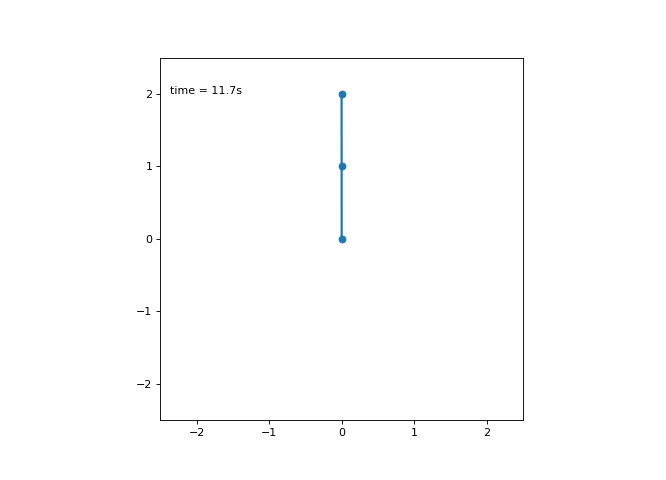

L1=1.0 m, L2=1.0 m
m1=1.0 kg, m2=1.0 kg
g=9.810 m/s^2
Theta1_init=0.000 rad, Theta2_init=0.000 rad
Omega1_init=0.000 rad/s, Omega2_init=0.000 rad/s
Kp=1.250, Kd=0.100, Ke=0.800
E_des=29.430
th1_des=3.142 rad, th2_des=3.142 rad
om1_des=0.000 rad/s, om1_des=0.000 rad/s
dt=0.025 sec


In [841]:
#Set the matplotlib animation to show 1 figure during the animation
%matplotlib nbagg     

n=800     #Number of samples

#Initialize the class and simulate the pendulum
pend=SwingUpAndBalancePendulum(control=True)
theta_sim,omega_sim,u_sim,E_sim,j2,end_e=pend.simulate(n)

#Define the figure for the animation
fig = plt.figure(figsize=(8.333, 6), dpi=80)
ax = fig.add_subplot(111,autoscale_on=False, xlim=(-2.5, 2.5), ylim=(-2.5, 2.5))   
ax.set_aspect('equal')
line, = ax.plot([], [], 'o-', lw=2)
time_template = 'time = %.1fs'
time_text = ax.text(pend.dt, 0.9, '', transform=ax.transAxes)
    
def init():
    line.set_data([], [])
    time_text.set_text('')
    return line, time_text

def animate(i):
    thisx = [0, j2[0,i],end_e[0,i]]
    thisy = [0, j2[1,i],end_e[1,i]]

    line.set_data(thisx, thisy)
    time_text.set_text(time_template % (i*pend.dt))
    return line, time_text

#Print the parameters of the simulation
pend.printParams()

#Show the animation
ani = animation.FuncAnimation(fig, animate, range(0, n), interval=pend.dt*1000, blit=True, init_func=init)
plt.show()


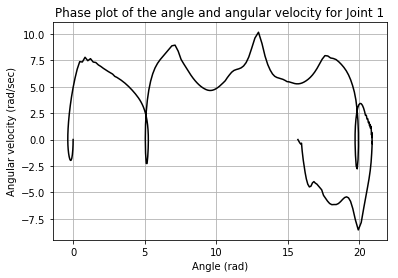

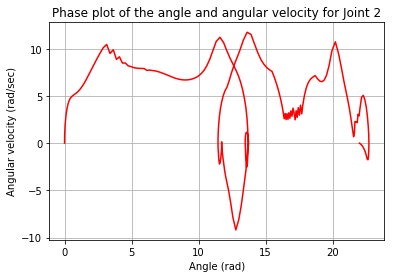

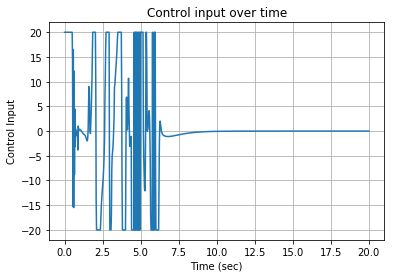

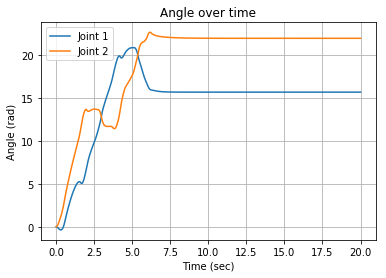

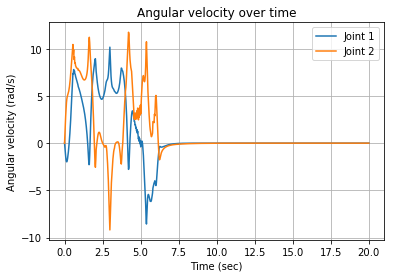

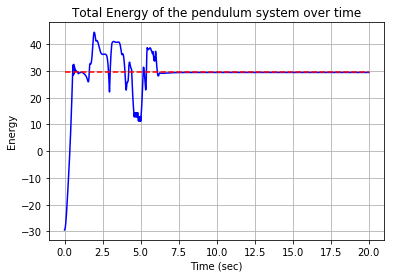

In [838]:
#Set the matplotlib plots to show the plots properly
%matplotlib inline

t=np.linspace(0,pend.dt*n,n)    #Create the time array

#Show the phase plot of the angle and angular velocity
plt.figure(0)
plt.plot(theta_sim[:,0],omega_sim[:,0],'k-')
plt.title("Phase plot of the angle and angular velocity for Joint 1")
plt.xlabel("Angle (rad)")
plt.ylabel("Angular velocity (rad/sec)")
plt.grid()

plt.figure(1)
plt.plot(theta_sim[:,1],omega_sim[:,1],'r-')
plt.title("Phase plot of the angle and angular velocity for Joint 2")
plt.xlabel("Angle (rad)")
plt.ylabel("Angular velocity (rad/sec)")
plt.grid()

#Show the plot of the control input over time
plt.figure(3)
plt.plot(t,u_sim)
plt.title("Control input over time")
plt.xlabel("Time (sec)")
plt.ylabel("Control Input")
plt.grid()

#Show the angles of the pendulum over time
plt.figure(4)
plt.plot(t,theta_sim)
plt.title("Angle over time")
plt.xlabel("Time (sec)")
plt.ylabel("Angle (rad)")
plt.grid()
plt.legend(["Joint 1","Joint 2"])

#Show the angular velocities of the pendulum over time
plt.figure(5)
plt.plot(t,omega_sim)
plt.title("Angular velocity over time")
plt.xlabel("Time (sec)")
plt.ylabel("Angular velocity (rad/s)")
plt.grid()
plt.legend(["Joint 1","Joint 2"])

#Show the total energy of the pendulum over time
plt.figure(6)
plt.plot(t,E_sim,'b-',t,pend.E_des*np.ones(len(t)),'r--')
plt.title("Total Energy of the pendulum system over time")
plt.xlabel("Time (sec)")
plt.ylabel("Energy")
plt.grid()

<IPython.core.display.Javascript object>


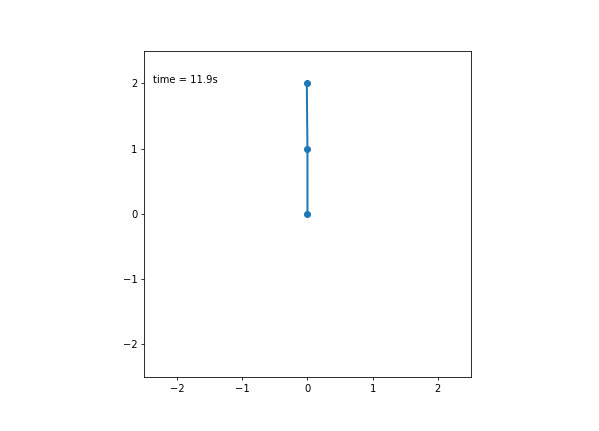

L1=1.0 m, L2=1.0 m
m1=1.0 kg, m2=1.0 kg
g=9.810 m/s^2
Theta1_init=0.000 rad, Theta2_init=1.000 rad
Omega1_init=0.000 rad/s, Omega2_init=0.000 rad/s
Kp=1.250, Kd=0.100, Ke=0.800
E_des=29.430
th1_des=3.142 rad, th2_des=3.142 rad
om1_des=0.000 rad/s, om1_des=0.000 rad/s
dt=0.025 sec


In [846]:
#Simulation for different initial states that yields an inverted pendulum in a reasonable amount of time

#Set the matplotlib animation to show 1 figure during the animation
%matplotlib nbagg

pend.PendulumParameters(th_init=[0,1],om_init=[0,0])
theta_sim,omega_sim,u_sim,E_sim,j2,end_e=pend.simulate(n)

#Define the figure for the animation
fig = plt.figure(figsize=(8.333, 6), dpi=80)
ax = fig.add_subplot(111,autoscale_on=False, xlim=(-2.5, 2.5), ylim=(-2.5, 2.5))   
ax.set_aspect('equal')
line, = ax.plot([], [], 'o-', lw=2)
time_template = 'time = %.1fs'
time_text = ax.text(pend.dt, 0.9, '', transform=ax.transAxes)

#Print the parameters of the simulation
pend.printParams()

#Show the animation
ani = animation.FuncAnimation(fig, animate, range(0, n), interval=pend.dt*1000, blit=True, init_func=init)
plt.show()

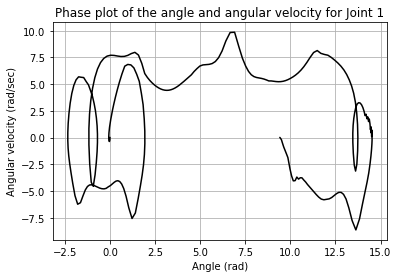

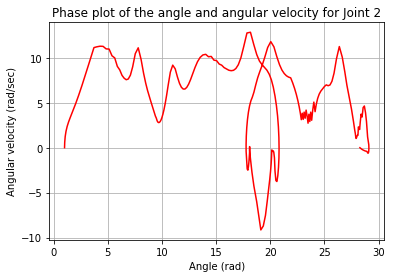

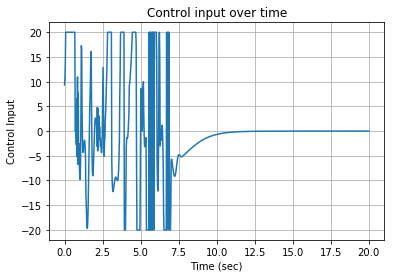

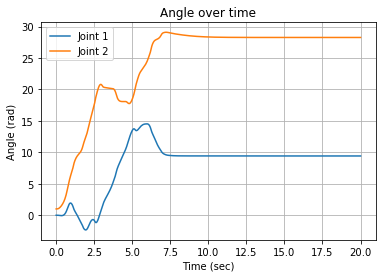

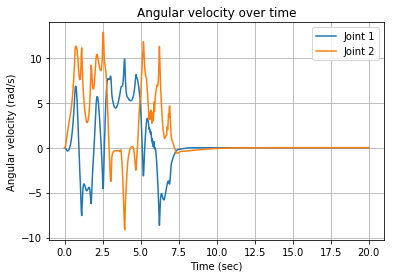

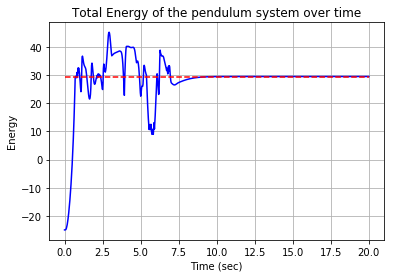

In [849]:
#Set the matplotlib plots to show the plots properly
%matplotlib inline

#Show the phase plot of the angle and angular velocity
plt.figure(0)
plt.plot(theta_sim[:,0],omega_sim[:,0],'k-')
plt.title("Phase plot of the angle and angular velocity for Joint 1")
plt.xlabel("Angle (rad)")
plt.ylabel("Angular velocity (rad/sec)")
plt.grid()

plt.figure(1)
plt.plot(theta_sim[:,1],omega_sim[:,1],'r-')
plt.title("Phase plot of the angle and angular velocity for Joint 2")
plt.xlabel("Angle (rad)")
plt.ylabel("Angular velocity (rad/sec)")
plt.grid()

#Show the plot of the control input over time
plt.figure(3)
plt.plot(t,u_sim)
plt.title("Control input over time")
plt.xlabel("Time (sec)")
plt.ylabel("Control Input")
plt.grid()

#Show the angles of the pendulum over time
plt.figure(4)
plt.plot(t,theta_sim)
plt.title("Angle over time")
plt.xlabel("Time (sec)")
plt.ylabel("Angle (rad)")
plt.grid()
plt.legend(["Joint 1","Joint 2"])

#Show the angular velocities of the pendulum over time
plt.figure(5)
plt.plot(t,omega_sim)
plt.title("Angular velocity over time")
plt.xlabel("Time (sec)")
plt.ylabel("Angular velocity (rad/s)")
plt.grid()
plt.legend(["Joint 1","Joint 2"])

#Show the total energy of the pendulum over time
plt.figure(6)
plt.plot(t,E_sim,'b-',t,pend.E_des*np.ones(len(t)),'r--')
plt.title("Total Energy of the pendulum system over time")
plt.xlabel("Time (sec)")
plt.ylabel("Energy")
plt.grid()